In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.python.ops import gen_array_ops
from PIL import Image

# the file remains as the same, but get different data (to be compared and calculates bandwidth mean)

In [47]:
NUMBER_NODES = 9

def load_data():
    train_df = pd.read_csv(os.path.join('..', 'DNN', 'datasets', f'dataset_{NUMBER_NODES}_train.csv'))
    val_df = pd.read_csv(os.path.join('..', 'DNN', 'datasets', f'dataset_{NUMBER_NODES}_val.csv'))
    test_df = pd.read_csv(os.path.join('..', 'DNN', 'datasets', f'dataset_{NUMBER_NODES}_test.csv'))

    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 
    def get_tuple_tensor_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber + 1: ].astype('float32') # Pula a banda otima na posicao 0
        return X, Y

    train_dataset = list(map(get_tuple_tensor_dataset, train_df.to_numpy()))
    val_dataset = list(map(get_tuple_tensor_dataset, val_df.to_numpy()))
    test_dataset = list(map(get_tuple_tensor_dataset, test_df.to_numpy()))

    X = []
    Y = []
    for x, y in train_dataset:
        X.append(x)
        Y.append(y)
    x_train = np.array(X)
    y_train = np.array(Y)

    X = []
    Y = []
    for x, y in test_dataset:
        X.append(x)
        Y.append(y)
    x_test = np.array(X)
    y_test = np.array(Y)

    X = []
    Y = []
    for x, y in val_dataset:
        X.append(x)
        Y.append(y)
    x_val = np.array(X)
    y_val = np.array(Y)

    x_train = np.concatenate((x_train, x_val))
    y_train = np.concatenate((y_train, y_val))


    return x_train, y_train, x_test, y_test

In [48]:
X, y, x_t, y_t = load_data()

In [49]:
print(X.shape)
print(y.shape)

(258188, 36)
(258188, 9)


In [50]:
def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def processDataToAdjImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = np.array([255.0, 255.0, 255.0])
    # data /= 255.0
    img = Image.fromarray(data, 'RGB')
    resized = img.resize((32, 32), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np

# def processDataToImage(graphInput):
#     graph_adj = getGraph(graphInput)
#     plt.imshow(graph_adj, cmap="gray")
#     plt.xticks([])
#     plt.yticks([])
#     plt.savefig(f'./Graph_adj_input_mse.png')
#     plt.clf()
#     image_input = tf.keras.preprocessing.image.load_img(f'./Graph_adj_input_mse.png')
#     image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
#     image_input_np = np.array(image_input_arr)
#     # image_input_np = image_input_np / 255.0

#     image_input_np = tf.image.resize(image_input_np, [32, 32])
#     return image_input_np


In [51]:
def getData_2(features, labels):
    train_images = []
    train_nodelist = []
    for graphInput, target in zip(features, labels):
        graphNodeList = target
        x_image = processDataToAdjImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
    # mlb = MultiLabelBinarizer()
    # labels = mlb.fit_transform(train_nodelist)
    return np.array(train_images), np.array(train_nodelist)

In [52]:
X_train, y_train = getData_2(X, y)
x_test, y_test = getData_2(x_t, y_t)

print(X_train.shape)
print(y_train.shape)

(258188, 32, 32, 3)
(258188, 9)


In [53]:
maeLoss = tf.keras.losses.MeanAbsoluteError()
loss_object = tf.keras.losses.MeanSquaredError()

def loss_repeated_labels(roundedOutput, true):
  true_used, true_indexes = tf.unique(tf.squeeze(true))
  used_labels, indexes, counts = tf.unique_with_counts(tf.squeeze(roundedOutput))
  counts = tf.cast(counts, tf.float32)
  # 1 - counts = quao longe os elementos de counts estão de repetir uma vez só (elemento unico)
  mse_ones_like = loss_object(tf.ones_like(counts), counts)
  mseIndexes = loss_object(tf.cast(true_indexes, tf.float32), tf.cast(indexes, tf.float32))
  # o quao longe os indexes estao de ser 0,1,2,3,4,5,6
  loss = tf.math.reduce_variance(counts) + mse_ones_like + mseIndexes
  return loss

def customLoss(true, pred):
  mae = maeLoss(true, pred)
  roundedOutput = tf.round(pred)
  loss_repeated = loss_repeated_labels(roundedOutput, true)
  return mae + loss_repeated


In [54]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(32, 32, 3)),
    layers.RandomRotation(0.2),
  ]
)

model = tf.keras.models.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUMBER_NODES)
])

model.compile(optimizer='adam',
              loss=customLoss,
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(x_test, y_test),
    epochs=128,
    batch_size=1
)

Epoch 1/128
 10169/258188 [>.............................] - ETA: 15:39 - loss: 16.7221 - accuracy: 0.3248

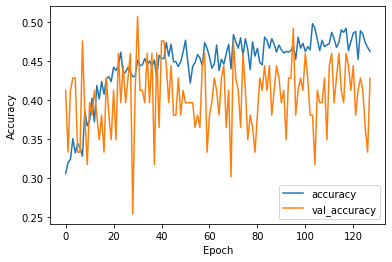

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

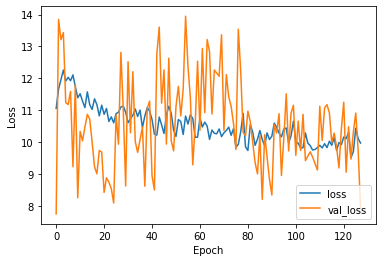

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
def count_repeats(output):
    counts = np.unique(np.round(output))
    repeated = NUMBER_NODES - counts.shape[0]
    return repeated

def get_valid_pred(pred):
    valid = np.ones(NUMBER_NODES)
    labels = np.arange(0, NUMBER_NODES)
    for i in labels:
        min_value = np.amin(pred)
        min_idx = np.where(pred == min_value)
        pred[min_idx] = 100
        valid[min_idx] = i
    return valid
    
def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    if nodelist.all() != None:
        L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    else:
        L = nx.laplacian_matrix(Graph)
    x, y = np.nonzero(L)
    return (x-y).max()

def get_array_from_image(graphnp):
    img = Image.fromarray(graphnp, 'RGB')
    img = img.convert('L')
    resized = img.resize((NUMBER_NODES, NUMBER_NODES), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np / 255

In [ ]:
import time

pred = model.predict(x_test)

sumTest_original = []
sumTest_pred = []
sumTest_true = []

count = 0
cases_with_repetition = 0

start = time.time()
for i in range(len(pred)):
    output = pred[i]
    quantity_repeated = count_repeats(np.round(output))
    print('Pred: ', output)
    print('True: ', y_test[i])
    if quantity_repeated != 0:
        cases_with_repetition += 1
    output = get_valid_pred(output)
    print('Pred valid: ', output)
    count += quantity_repeated

    graph = get_array_from_image(x_test[i])

    original_band = get_bandwidth(graph, np.array(None))
    sumTest_original.append(original_band)

    pred_band = get_bandwidth(graph, output)
    sumTest_pred.append(pred_band)

    true_band = get_bandwidth(graph, y_test[i])
    sumTest_true.append(true_band)

    # print("Bandwidth")
    # print(original_band)
    # print(pred_band)
    # print(true_band)
end = time.time()

Pred:  [0.9528729 4.3681035 5.104821  2.0635056 2.9230218 3.1553514 3.1805334]
True:  [1. 5. 6. 0. 3. 2. 4.]
Pred valid:  [0. 5. 6. 1. 2. 3. 4.]
Pred:  [2.343595  1.7145927 4.523112  5.7478104 4.479965  1.3050764 2.907851 ]
True:  [3. 0. 6. 4. 5. 2. 1.]
Pred valid:  [2. 1. 5. 6. 4. 0. 3.]
Pred:  [1.1935221 4.204269  5.209837  2.0783045 2.716316  3.3746445 3.3682594]
True:  [1. 5. 6. 0. 2. 4. 3.]
Pred valid:  [0. 5. 6. 1. 2. 4. 3.]
Pred:  [1.2845895 3.8657353 5.2329407 2.4623444 3.3735247 3.11071   2.9546251]
True:  [2. 0. 4. 6. 5. 1. 3.]
Pred valid:  [0. 5. 6. 1. 4. 3. 2.]
Pred:  [1.8475041 1.3470507 4.330965  5.1372466 4.746283  1.440069  2.761214 ]
True:  [1. 2. 6. 4. 0. 5. 3.]
Pred valid:  [2. 0. 4. 6. 5. 1. 3.]
Pred:  [1.964856  1.2442894 4.2997937 5.2965293 4.163316  1.2494352 2.6198938]
True:  [4. 0. 2. 6. 5. 3. 1.]
Pred valid:  [2. 0. 5. 6. 4. 1. 3.]
Pred:  [2.1331506 2.1233373 4.6810946 4.6055064 4.4281125 1.7897176 2.9792027]
True:  [2. 3. 1. 4. 5. 6. 0.]
Pred valid:  [2. 1. 6

In [ ]:
print('Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 - ', count)
print('Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 - ', cases_with_repetition)
test_length = pred.shape[0]
print('Test length - ', test_length)
print('Time- ', (end - start) / test_length)

print("Bandwidth mean±std")
print(f'{np.mean(sumTest_original)}±{np.std(sumTest_original)}')
print("Pred bandwidth mean±std")
print(f'{np.mean(sumTest_pred)}±{np.std(sumTest_pred)}')
print("True bandwidth mean±std")
print(f'{np.mean(sumTest_true)}±{np.std(sumTest_true)}')

Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 -  152
Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 -  53
Test length -  63
Time-  0.004179837211729988
Bandwidth mean±std
5.904761904761905±0.2935435239509036
Pred bandwidth mean±std
4.507936507936508±0.7532578106479156
True bandwidth mean±std
3.1904761904761907±0.7095078297976829
